# Creating Customer Segments

---

## Introduction

In this project, we will analyze a dataset containing data on various customers annual spending amounts (reported in *monetary units*) of diverse product categories for internal structure. One goal of this project is to best describe the variation in the different types of customers that a wholesale distributor interacts with: Doing so would equip the distributor with insight into how to best structure their delivery service to meet the needs of each customer.

The dataset for this project can be found on the [UCI Machine Learning Repository](https://archive.ics.uci.edu/ml/datasets/Wholesale+customers).

For the purposes of this project, the features `'Channel'` and `'Region'` will be excluded in the analysis, with focus instead on the six product categories recorded for customers.

As a technical requisite, we are going first to load the necessary Python libraries required for this project.

In [1]:
# Needed imports:
%matplotlib inline
%config InlineBackend.figure_format = "retina"
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import visuals as vs
import seaborn as sns
from IPython.display import display
from sklearn.cross_validation import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn.decomposition import PCA
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score

/opt/conda/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


---

## Data Exploration

In this section, we will begin exploring the data through visualizations and code to understand how each feature is related to the others. We will observe a statistical description of the dataset, consider the relevance of each feature, and select a few sample data points from the dataset which we will track through the course of this project.

First, we can begin loading the wholesale customers dataset

*Nota Bene:* We will know the dataset loaded successfully if the size of the dataset is reported.

In [2]:
# Load the wholesale customers dataset:
try:
    data = pd.read_csv("customers.csv")
    data.drop(["Region", "Channel"], axis=1, inplace=True)
    print("=> Dataset loaded: Wholesale customers dataset has {} samples with {} features each.".format(*data.shape))
except:
    print("=> Dataset could not be loaded: 'customers.csv' is missing.")

=> Dataset loaded: Wholesale customers dataset has 440 samples with 6 features each.


Now, we can run the code block below to observe a statistical description of the dataset.

*Nota Bene:* The dataset is composed of six important product categories: **'Fresh'**, **'Milk'**, **'Grocery'**, **'Frozen'**, **'Detergents_Paper'**, and **'Delicatessen'**.

In [3]:
# Display a description of the dataset:
display(data.describe())

,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicatessen
count,440.000000,440.000000,440.000000,440.000000,440.000000,440.000000
mean,12000.297727,5796.265909,7951.277273,3071.931818,2881.493182,1524.870455
std,12647.328865,7380.377175,9503.162829,4854.673333,4767.854448,2820.105937
min,3.000000,55.000000,3.000000,25.000000,3.000000,3.000000
25%,3127.750000,1533.000000,2153.000000,742.250000,256.750000,408.250000
50%,8504.000000,3627.000000,4755.500000,1526.000000,816.500000,965.500000
75%,16933.750000,7190.250000,10655.750000,3554.250000,3922.000000,1820.250000
max,112151.000000,73498.000000,92780.000000,60869.000000,40827.000000,47943.000000


### Selecting Samples

To get a better understanding of the customers and how their data will transform through the analysis, it would be best to select a few sample data points and explore them in more detail.

In the code block below, we are going to add **three** indices to the `indices` list which will represent the customers to track.

*Nota Bene:* It is a good idea to obtain customers that vary significantly from one another.

In [4]:
# Select three indices to sample from the dataset:
indices = [42, 126, 378]

# Create a DataFrame of the chosen samples:
samples = pd.DataFrame(data.loc[indices], columns=data.keys()).reset_index(drop=True)
print("=> Chosen samples of wholesale customers dataset:")
display(samples)

=> Chosen samples of wholesale customers dataset:


,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicatessen
0,10850,7555,14961,188,6899,46
1,19219,1840,1658,8195,349,483
2,3225,3294,1902,282,68,1114


Here, we are going to consider the total purchase cost of each product category and the statistical description of the dataset above for our sample customers.  

What kind of establishment (customer) could each of the three samples we've chosen represent?

Examples of establishments include places like markets, cafes, delis, wholesale retailers, among many others...

If we take the mean values for reference to compare our samples with, we can say that:
- The first establishment concentrates its expenses on milk products, grocery products, and detergents and paper products (all above their respective third quantile): This type of characteristics can let us think about an important market place, dedicated to non perishable everyday products.
- The second establishment concentrates its expenses on fresh products and frozen products (all above their respective third quantile): This type of characteristics can let us think about a wholesaler and food distributor specialized on fresh and frozen products, for restaurants and fast foods for example.
- The third establishment has all its expenses below each category mean value: This can lead us to think about a little neighborhood market local place.

### Feature Relevance

One interesting thought to consider is if one (or more) of the six product categories is actually relevant for understanding customer purchasing: That is to say, is it possible to determine whether customers purchasing some amount of one category of products will necessarily purchase some proportional amount of another category of products?

We can make this determination quite easily by training a supervised regression learner on a subset of the data with one feature removed, and then score how well that model can predict the removed feature.

In the code block below, we are going to implement the following:
- Assign `new_data` a copy of the data by removing a feature of our choice using the `DataFrame.drop` function.
- Use `sklearn.cross_validation.train_test_split` to split the dataset into training and testing sets (we are going to use the removed feature as our target label and set a `test_size` of `0.25` with a `random_state`).
- Import a decision tree regressor, set a `random_state`, and fit the learner to the training data.
- Report the prediction score of the testing set using the regressor's `score` function.

In [5]:
# Make a copy of the DataFrame and drop the given feature:
new_data = data.drop(["Milk"], axis=1)
feature = data["Milk"]

# Split the data into training and testing sets:
X_train, X_test, y_train, y_test = train_test_split(new_data,
                                                    feature,
                                                    test_size=0.25,
                                                    random_state=42)

# Create a decision tree regressor and fit it to the training set:
regressor = DecisionTreeRegressor(random_state=42)
regressor.fit(X_train, y_train)

# Report the score of the prediction using the testing set:
score = regressor.score(X_test, y_test)
print("The coefficient of determination R2 of the prediction is {:.2f}".format(score))

The coefficient of determination R2 of the prediction is 0.16


Above, we have chosen the annual spending on milk products as the feature to predict, and, thanks to the decision tree regressor we have built on the training set, we have obtained a coefficient of determination $R^2$ of the prediction on the testing set of 0.16.

The values for $R^2$ range from 0 to 1, which captures the percentage of squared correlation between the predicted and actual values of the target variable: A model with an $R^2$ of 0 is no better than a model that always predicts the mean of the target variable, whereas a model with an $R^2$ of 1 perfectly predicts the target variable. Any value between 0 and 1 indicates what percentage of the target variable, using this model, can be explained by the features.

*Nota Bene:* A model can be given a negative $R^2$ as well, which indicates that the model is arbitrarily worse than one that always predicts the mean of the target variable.

Thus, here, with a coefficient $R^2$ of 0.16, we can conclude that the annual spending on milk products is difficult to predict using the other features of the dataset, and that it is necessary for identifying customers spending habits.

### Visualize Feature Distributions

To get a better understanding of the data, we can now construct a scatter matrix of each of the six product features present in the dataset.

For example, if a feature is relevant for identifying a specific customer, then the scatter matrix below will not show any correlation between that feature and the others.

Conversely, if a feature is not relevant for identifying a specific customer, the scatter matrix will show a correlation between that feature and another feature in the data.

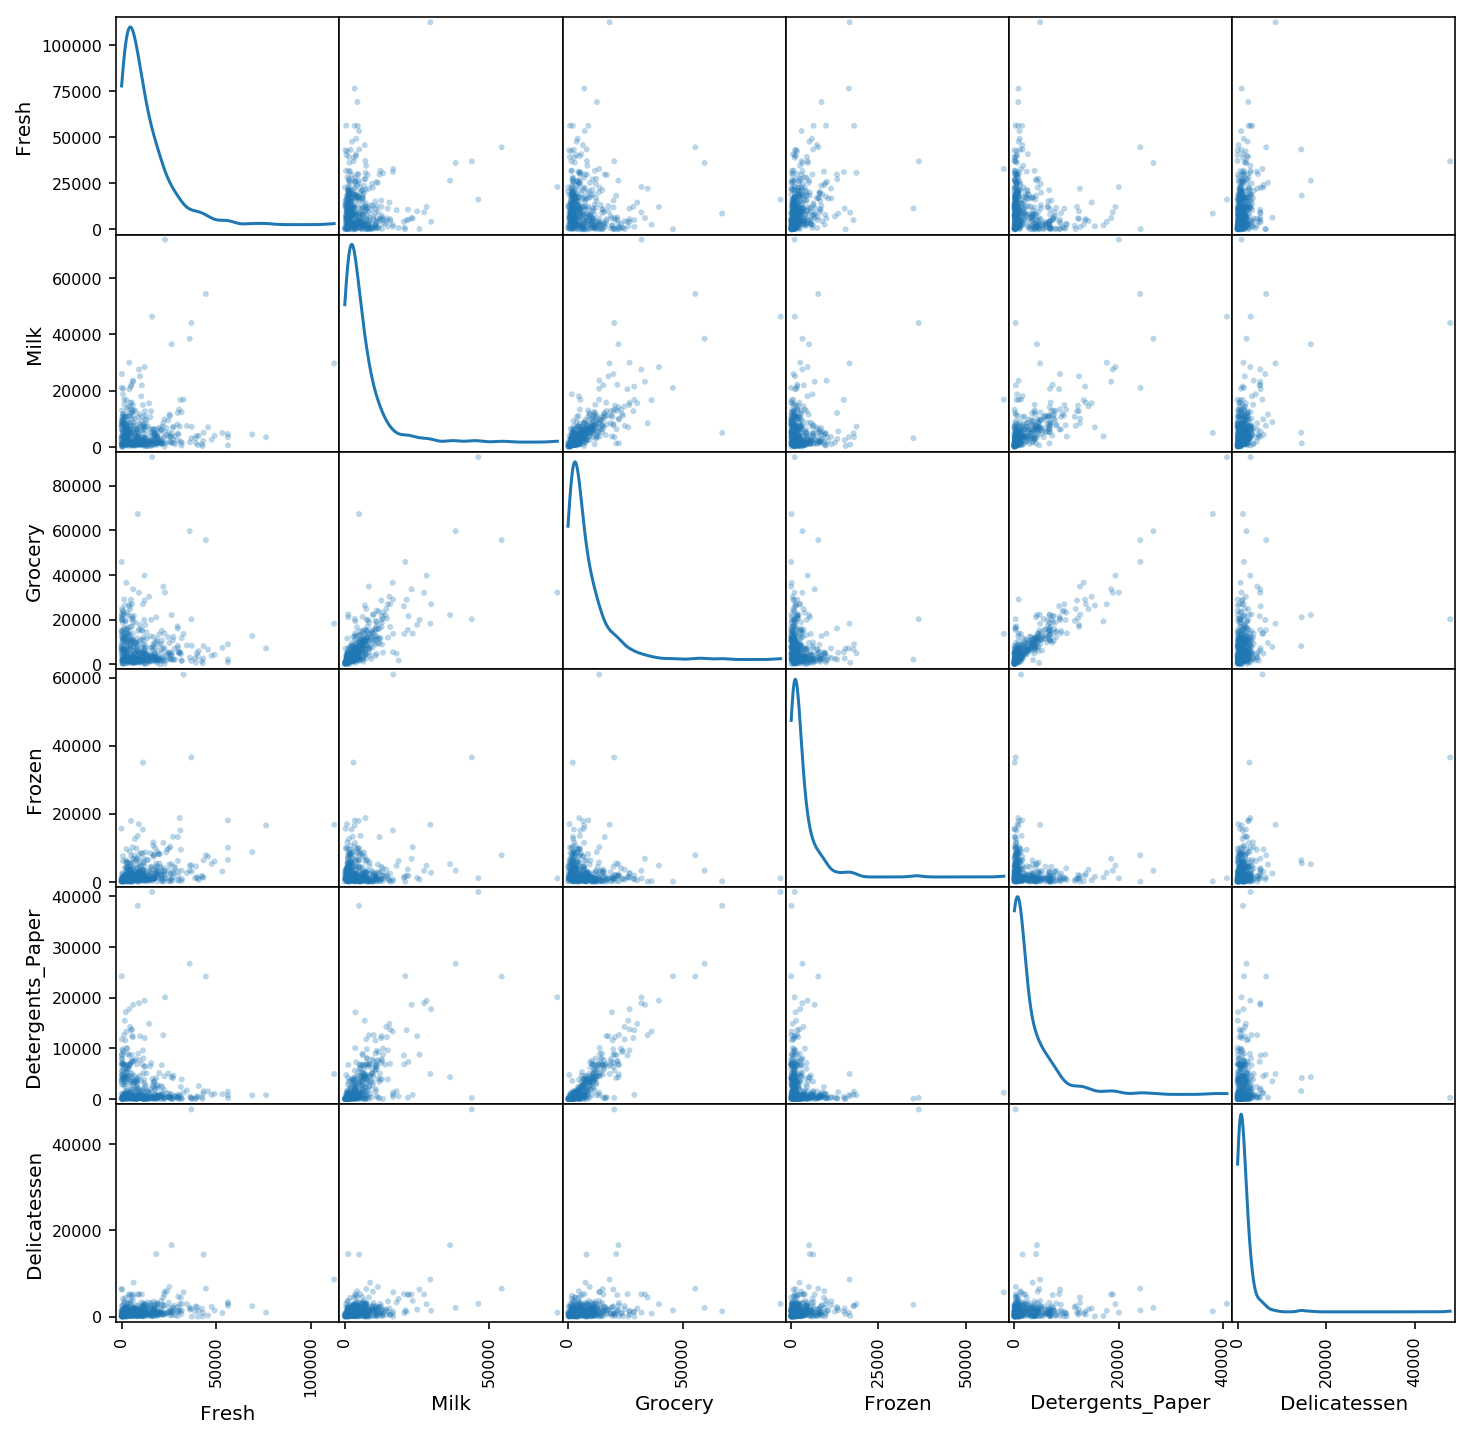

In [6]:
# Produce a scatter matrix for each pair of features in the dataset:
pd.plotting.scatter_matrix(data, alpha=0.3, figsize=(12,12), diagonal="kde");

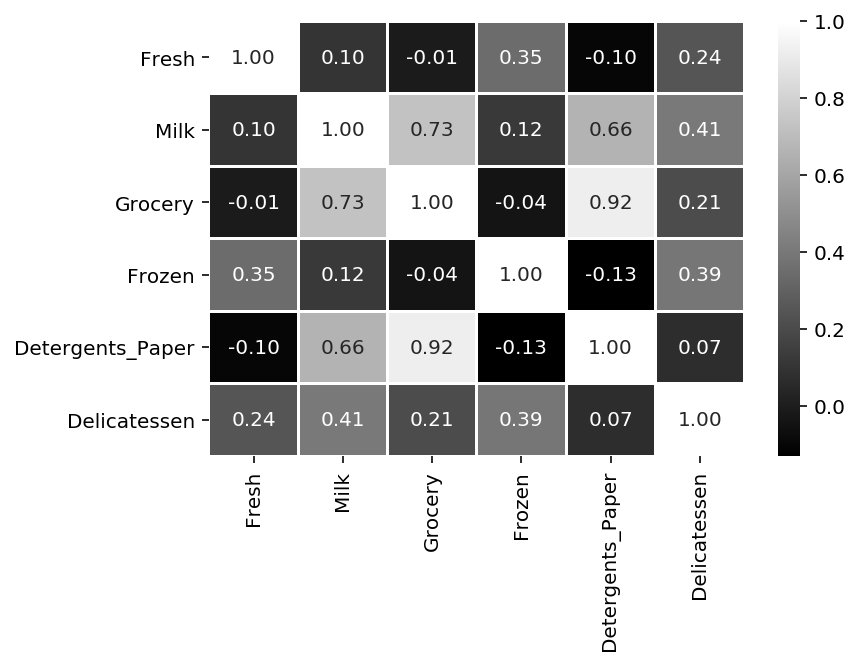

In [7]:
# Visualize feature correlations:
sns.heatmap(data.corr(), fmt=".2f", annot=True, linewidths=1., cmap=plt.cm.gist_gray);

As it can be seen in the first graph we have displayed, the six features present a clearly right-skewed distribution, accompanied by a lot of points next to 0 and some outliers to consider in each case. 

If we now put the focus on the second graph we have displayed, we can note three pairs of features which exhibit a notable degree of correlation:
- Annual spendings on grocery and detergents and paper products (0.92)
- Annual spendings on milk and grocery products (0.73)
- Annual spendings on milk and detergents and paper products (0.66)

Thus, it appears that the feature embbeding annual spending on milk products is reasonably correlated to other features, element which leads us toward a different perspective than the one we have had previously.

---

## Data Preprocessing

In this section, we will preprocess the data to create a better representation of customers by performing a scaling on the data and detecting (and optionally removing) outliers: Preprocessing data is often times a critical step in assuring that results we obtain from our analysis are significant and meaningful.

### Feature Scaling

If data is not normally distributed, especially if the mean and median vary significantly (indicating a large skew), it is most [often appropriate](http://econbrowser.com/archives/2014/02/use-of-logarithms-in-economics) to apply a non-linear scaling — particularly for financial data. One way to achieve this scaling is by using a [Box-Cox test](http://scipy.github.io/devdocs/generated/scipy.stats.boxcox.html), which calculates the best power transformation of the data that reduces skewness. A simpler approach which can work in most cases would be applying the natural logarithm.

In the code block below, we are going to implement the following:
- Assign a copy of the data to `log_data` after applying logarithmic scaling (we are going to use the `np.log` function for this).
- Assign a copy of the sample data to `log_samples` after applying logarithmic scaling (again, we are going to use `np.log`).

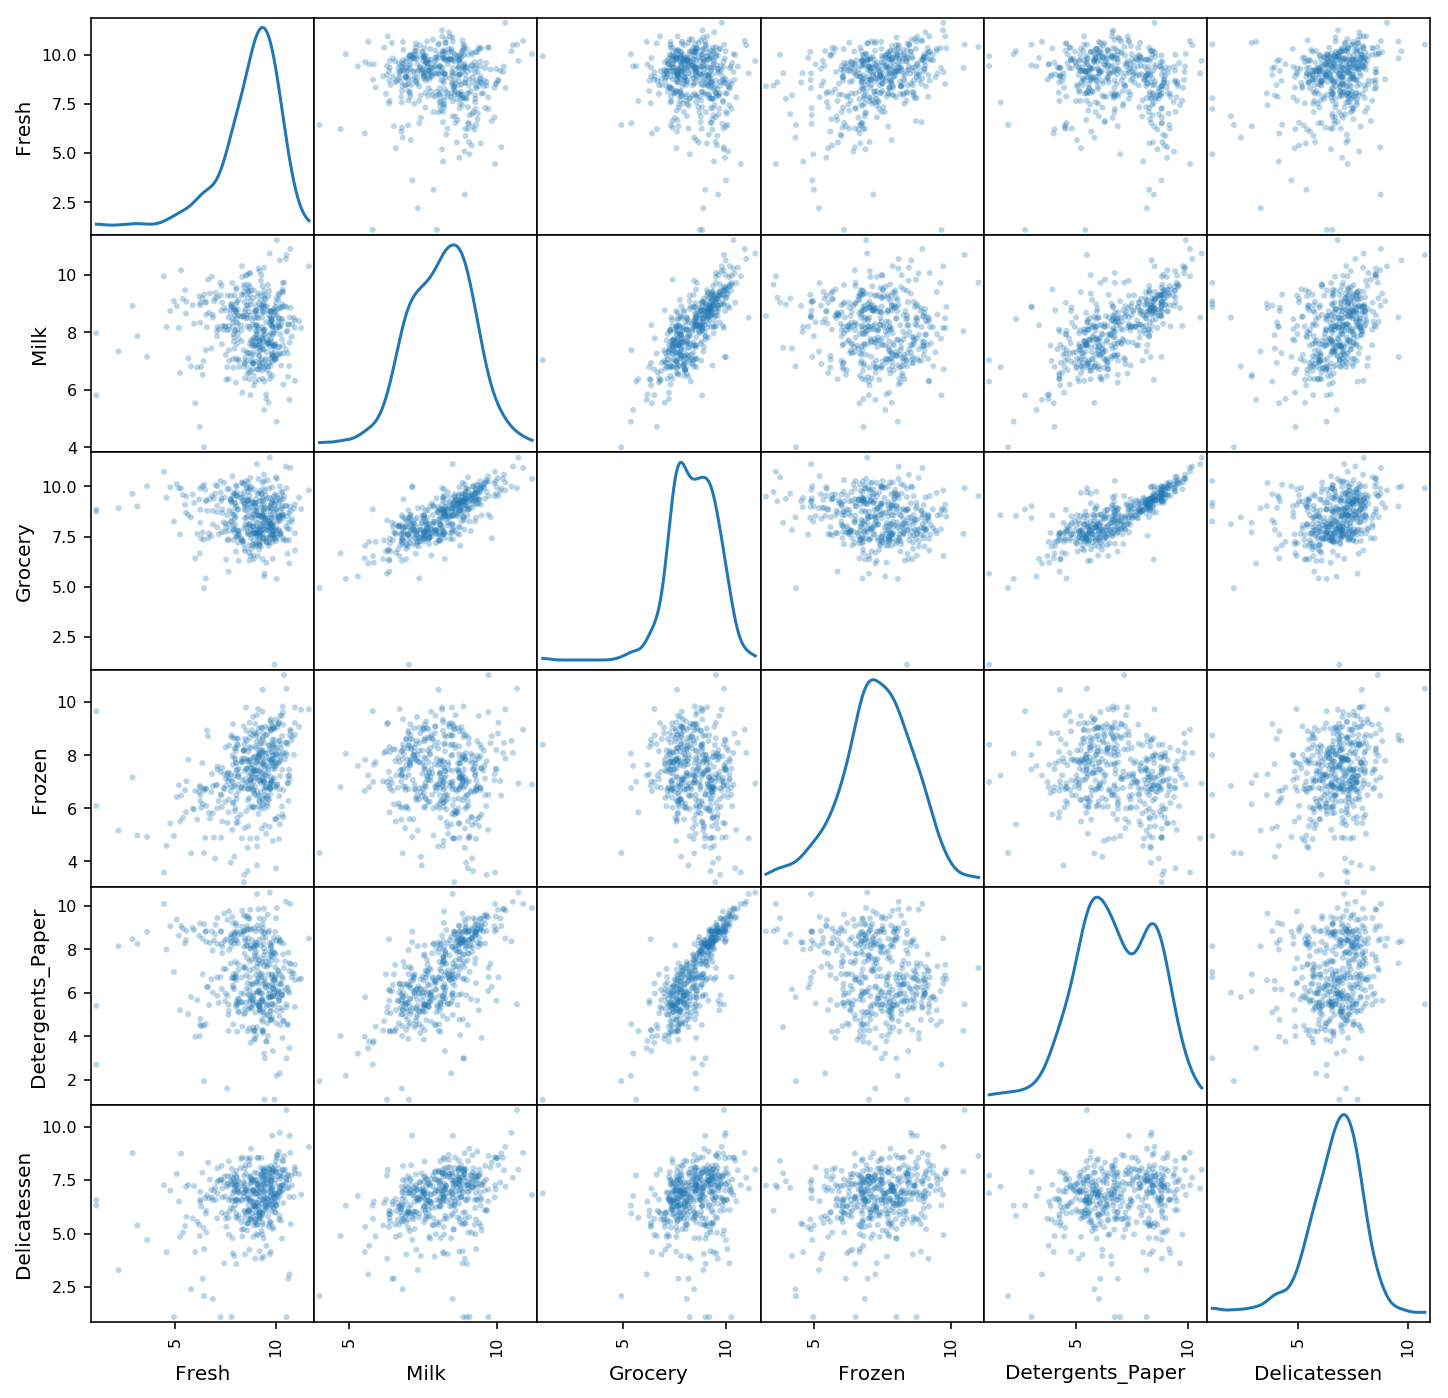

In [8]:
# Scale the data using the natural logarithm:
log_data = np.log(data.copy())

# Scale the sample data using the natural logarithm:
log_samples = np.log(samples.copy())

# Produce a scatter matrix for each pair of newly-transformed features:
pd.plotting.scatter_matrix(log_data, alpha=0.3, figsize=(12,12), diagonal="kde");

### Observation

After applying a natural logarithm scaling to the data, the distribution of each feature should appear much more normal. For any pairs of features we may have identified earlier as being correlated, we can observe here whether that correlation is still present (and whether it is now stronger or weaker than before).

Furtheremore, we are going to run the code below to see how the sample data has changed after having the natural logarithm applied to it.

In [9]:
# Display the log-transformed sample data:
display(log_samples)

,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicatessen
0,9.291920,8.929965,9.613202,5.236442,8.839132,3.828641
1,9.863655,7.517521,7.413367,9.011279,5.855072,6.180017
2,8.078688,8.099858,7.550661,5.641907,4.219508,7.015712


### Outlier Detection

Detecting outliers in the data is extremely important in the data preprocessing step of any analysis. The presence of outliers can often skew results which take into consideration these data points. There are many "rules of thumb" for what constitutes an outlier in a dataset. Here, we will use [Tukey's Method for identfying outliers](https://www.kdnuggets.com/2017/01/3-methods-deal-outliers.html): An *outlier step* is calculated as 1.5 times the interquartile range (IQR). A data point with a feature that is beyond an outlier step outside of the IQR for that feature is considered abnormal.

In the code block below, we are going to implement the following:
- Assign the value of the 25th percentile for the given feature to `Q1` (thanks to `np.percentile`).
- Assign the value of the 75th percentile for the given feature to `Q3` (again, thanks to `np.percentile`).
- Assign the calculation of an outlier step for the given feature to `step`.
- Optionally remove data points from the dataset by adding indices to the `outliers` list.

*Nota Bene:* If we choose to remove any outliers, we have to ensure that the sample data does not contain any of these points!

Once you have performed this implementation, the dataset will be stored in the variable `good_data`.

In [10]:
# Set outliers list:
outliers_list = []

# For each feature find the data points with extreme high or low values:
for feature in log_data.keys():
    
    # Calculate Q1 (25th percentile of the data) for the given feature:
    Q1 = np.percentile(log_data[feature], 25)
    
    # Calculate Q3 (75th percentile of the data) for the given feature:
    Q3 = np.percentile(log_data[feature], 75)
    
    # Use the interquartile range to calculate an outlier step (1.5 times the interquartile range):
    step = 1.5*(Q3 - Q1)
    
    # Display the outliers:
    print("Data points considered outliers for the feature '{}':".format(feature))
    display(log_data[~((log_data[feature] >= Q1 - step) & (log_data[feature] <= Q3 + step))])
    
    # Add feature outliers to general outliers list:
    outliers_list.extend(log_data[~((log_data[feature] >= Q1 - step) & (log_data[feature] <= Q3 + step))].index)
    
# Work on outliers list:
tukey_outliers_list = []
remove_outliers_list = []
for element in outliers_list:
    if element not in tukey_outliers_list:
        tukey_outliers_list.append(element)
    else:
        if element not in remove_outliers_list:
            remove_outliers_list.append(element)
print("=> Following Tukey's method, the outliers list to consider is {}".format(tukey_outliers_list))
print("=> Number of elements in the outliers list: {}".format(len(tukey_outliers_list)))
print("=> The outliers list we are going to remove is {}".format(remove_outliers_list))

# Remove the outliers from the data:
good_data = log_data.drop(log_data.index[remove_outliers_list]).reset_index(drop=True)

Data points considered outliers for the feature 'Fresh':


,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicatessen
65,4.442651,9.950323,10.732651,3.583519,10.095388,7.260523
66,2.197225,7.335634,8.911530,5.164786,8.151333,3.295837
81,5.389072,9.163249,9.575192,5.645447,8.964184,5.049856
95,1.098612,7.979339,8.740657,6.086775,5.407172,6.563856
96,3.135494,7.869402,9.001839,4.976734,8.262043,5.379897
128,4.941642,9.087834,8.248791,4.955827,6.967909,1.098612
171,5.298317,10.160530,9.894245,6.478510,9.079434,8.740337
193,5.192957,8.156223,9.917982,6.865891,8.633731,6.501290
218,2.890372,8.923191,9.629380,7.158514,8.475746,8.759669
304,5.081404,8.917311,10.117510,6.424869,9.374413,7.787382


Data points considered outliers for the feature 'Milk':


,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicatessen
86,10.039983,11.205013,10.377047,6.894670,9.906981,6.805723
98,6.220590,4.718499,6.656727,6.796824,4.025352,4.882802
154,6.432940,4.007333,4.919981,4.317488,1.945910,2.079442
356,10.029503,4.897840,5.384495,8.057377,2.197225,6.306275


Data points considered outliers for the feature 'Grocery':


,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicatessen
75,9.923192,7.036148,1.098612,8.390949,1.098612,6.882437
154,6.432940,4.007333,4.919981,4.317488,1.945910,2.079442


Data points considered outliers for the feature 'Frozen':


,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicatessen
38,8.431853,9.663261,9.723703,3.496508,8.847360,6.070738
57,8.597297,9.203618,9.257892,3.637586,8.932213,7.156177
65,4.442651,9.950323,10.732651,3.583519,10.095388,7.260523
145,10.000569,9.034080,10.457143,3.737670,9.440738,8.396155
175,7.759187,8.967632,9.382106,3.951244,8.341887,7.436617
264,6.978214,9.177714,9.645041,4.110874,8.696176,7.142827
325,10.395650,9.728181,9.519735,11.016479,7.148346,8.632128
420,8.402007,8.569026,9.490015,3.218876,8.827321,7.239215
429,9.060331,7.467371,8.183118,3.850148,4.430817,7.824446
439,7.932721,7.437206,7.828038,4.174387,6.167516,3.951244


Data points considered outliers for the feature 'Detergents_Paper':


,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicatessen
75,9.923192,7.036148,1.098612,8.390949,1.098612,6.882437
161,9.428190,6.291569,5.645447,6.995766,1.098612,7.711101


Data points considered outliers for the feature 'Delicatessen':


,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicatessen
66,2.197225,7.335634,8.911530,5.164786,8.151333,3.295837
109,7.248504,9.724899,10.274568,6.511745,6.728629,1.098612
128,4.941642,9.087834,8.248791,4.955827,6.967909,1.098612
137,8.034955,8.997147,9.021840,6.493754,6.580639,3.583519
142,10.519646,8.875147,9.018332,8.004700,2.995732,1.098612
154,6.432940,4.007333,4.919981,4.317488,1.945910,2.079442
183,10.514529,10.690808,9.911952,10.505999,5.476464,10.777768
184,5.789960,6.822197,8.457443,4.304065,5.811141,2.397895
187,7.798933,8.987447,9.192075,8.743372,8.148735,1.098612
203,6.368187,6.529419,7.703459,6.150603,6.860664,2.890372


=> Following Tukey's method, the outliers list to consider is [65, 66, 81, 95, 96, 128, 171, 193, 218, 304, 305, 338, 353, 355, 357, 412, 86, 98, 154, 356, 75, 38, 57, 145, 175, 264, 325, 420, 429, 439, 161, 109, 137, 142, 183, 184, 187, 203, 233, 285, 289, 343]
=> Number of elements in the outliers list: 42
=> The outliers list we are going to remove is [154, 65, 75, 66, 128]


As it can be observed above, the data points with indices 154, 65, 75, 66 and 128 appeared to be considered outliers for more than one feature: We are going to remove them.

Indeed, if we count the number of outliers following Tukey's method, we arrived to 42, approximatively 10% of the entire dataset, that's too much information to remove: It is for that we are only going to remove the data points appearing as outliers for more than one feature.

---

## Feature Transformation

In this section, we will use *principal component analysis* (PCA) to draw conclusions about the underlying structure of the wholesale customer data. Since using PCA on a dataset calculates the dimensions which best maximize variance, we will find which compound combinations of features best describe customers.

### PCA

Now that the data has been scaled to a more normal distribution and has had any necessary outliers removed, we can now apply PCA to the `good_data` to discover which dimensions about the data best maximize the variance of features involved. In addition to finding these dimensions, PCA will also report the *explained variance ratio* of each dimension (how much variance within the data is explained by that dimension alone).

*Nota Bene:* A component (dimension) from PCA can be considered a new "feature" of the space, however it is a composition of the original features present in the data.

In the code block below, we are going to implement the following:
- Assign the results of fitting PCA in six dimensions with `good_data` to `pca`.
- Apply a PCA transformation of `log_samples` using `pca.transform`, and assign the results to `pca_samples`.

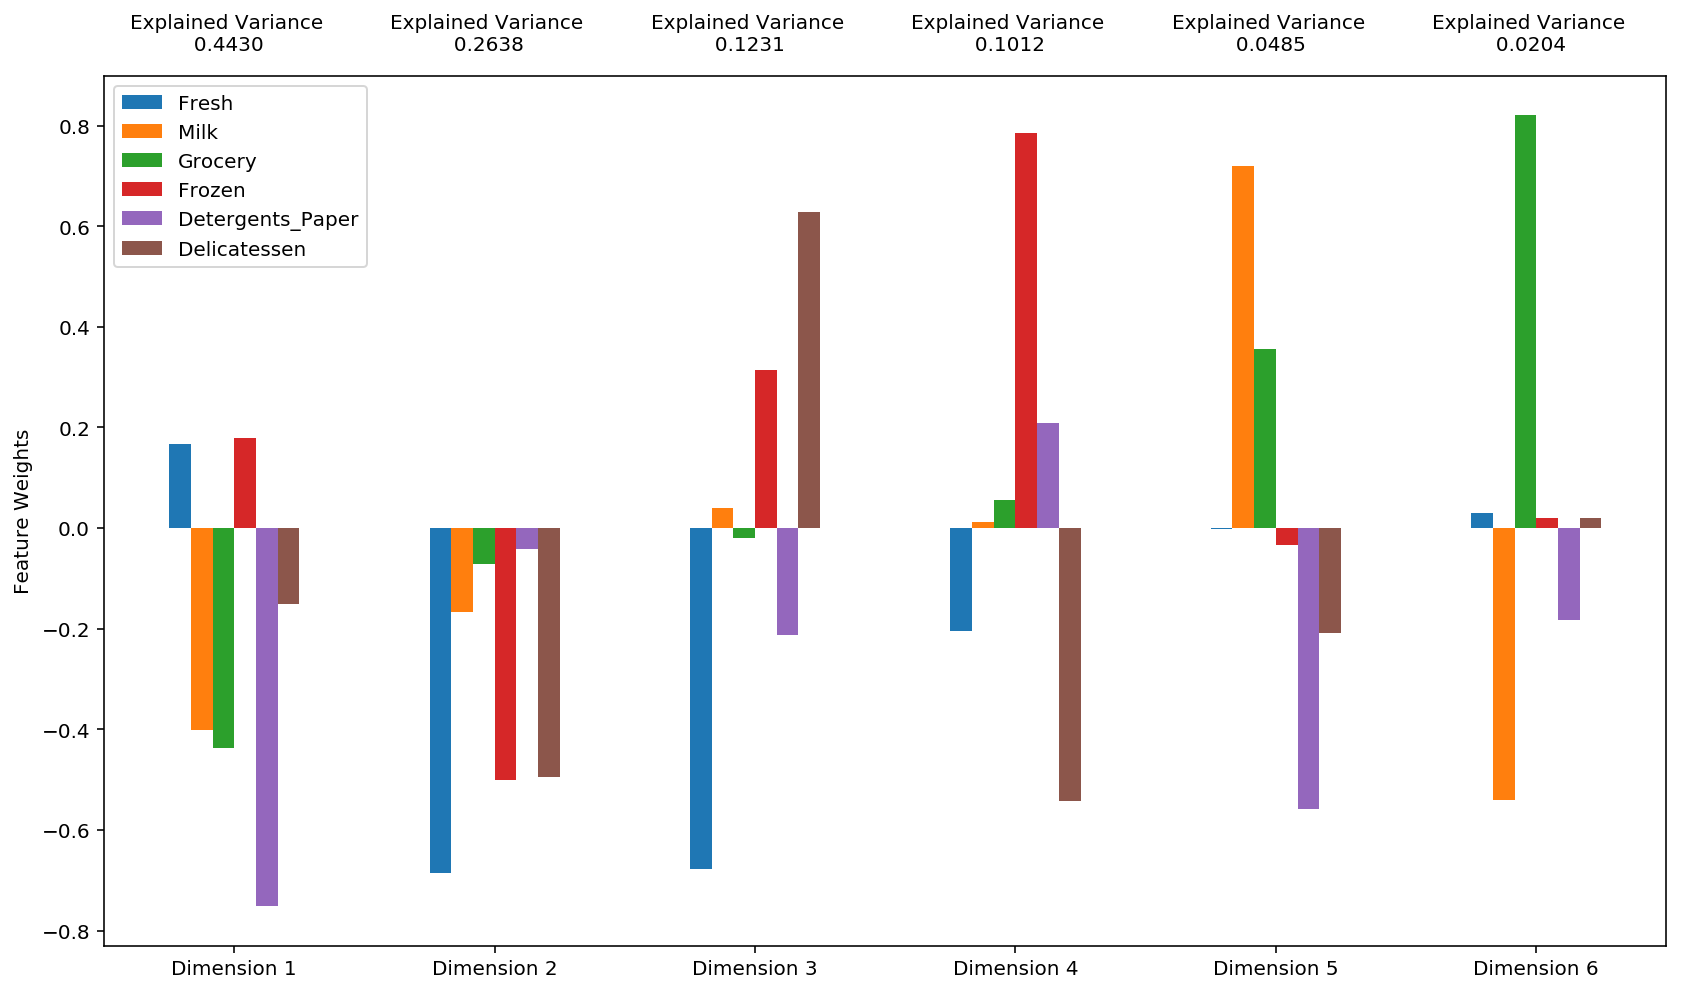

In [11]:
# Apply PCA by fitting the good data with the same number of dimensions as features:
pca = PCA(n_components=6, random_state=42)
pca.fit(good_data)

# Transform log_samples using the PCA fit above:
pca_samples = pca.transform(log_samples)

# Generate PCA results plot:
pca_results = vs.pca_results(good_data, pca)

In [12]:
# Some stats:
print("*** Explained variance for each dimension:")
print(pca_results["Explained Variance"])
print("\n*** Cumulative explained variance:")
print(pca_results["Explained Variance"].cumsum())

*** Explained variance for each dimension:
Dimension 1    0.4430
Dimension 2    0.2638
Dimension 3    0.1231
Dimension 4    0.1012
Dimension 5    0.0485
Dimension 6    0.0204
Name: Explained Variance, dtype: float64

*** Cumulative explained variance:
Dimension 1    0.4430
Dimension 2    0.7068
Dimension 3    0.8299
Dimension 4    0.9311
Dimension 5    0.9796
Dimension 6    1.0000
Name: Explained Variance, dtype: float64


As it can be seen above, 70.68% of the variance in the data is explained in total by the first and second principal components, and 93.11% of the variance in the data is explained by the first four principal components.

If we now comment the visualization graph provided above, we can say that:
- In respect to dimension 1, its cumulative explained variance is 44.30%, and this first principal component mainly increases with decreasing values of annual spendings on milk, grocery, and detergents and paper products (all are negatively correlated).
- In respect to dimension 2, its cummulative explained variance is 70.68%, and this second principal component mainly increases with decreasing values of annual spendings on fresh, frozen and delicatessen products (all are negatively correlated).
- In respect to dimension 3, its cummulative explained variance is 82.99%, and this third princpal component mainly increases with decreasing values of annual spending on fresh products (it is negatively correlated) and increasing values of annual spendings on frozen and delicatessen products (all are positively correlated).
- In respect to dimension 4, its cummulative variance is 93.11%, and this fourth principal component mainly increases with decreasing values of annual spending on delicatessen product (it is negatively correlated) and increasing values of annual spending on frozen products (it is positively correlated).
- In respect to dimension 5, its cummulative variance is 97.96% and this fifth principal component mainly increases with increasing values of annual spendings on fresh and grocery products (all are positively correlated) and decreasing values of annual spending on detergents and paper products (all are negatively correlated).
- In respect to dimension 6, its cummulative variance is, as expected, 100.00%, and this sixth principal component mainly increases with decreasing values of annual spending on milk products (it is negatively correlated) and increasing values of annual spending on grocery products (it is positively correlated).

### Observation

We can now run the code below to see how the log-transformed sample data has changed after having a PCA transformation applied to it in six dimensions.

In [13]:
# Display sample log-data after having a PCA transformation applied:
display(pd.DataFrame(np.round(pca_samples, 4), columns=pca_results.index.values))

,Dimension 1,Dimension 2,Dimension 3,Dimension 4,Dimension 5,Dimension 6
0,-2.2146,1.7988,-3.2371,0.3088,0.5148,0.0568
1,1.9745,-1.1263,-0.3393,1.1157,-0.2356,-0.3004
2,1.8850,1.3340,0.7006,-1.9471,1.0862,-0.3087


### Dimensionality Reduction

When using principal component analysis, one of the main goals is to reduce the dimensionality of the data (in effect, reducing the complexity of the problem). Dimensionality reduction comes at a cost: Fewer dimensions used implies less of the total variance in the data is being explained. Because of this, the *cumulative explained variance ratio* is extremely important for knowing how many dimensions are necessary for the problem. Additionally, if a signifiant amount of variance is explained by only two or three dimensions, the reduced data can be visualized afterwards.

In the code block below, we are going to implement the following:
- Assign the results of fitting PCA in two dimensions with `good_data` to `pca`.
- Apply a PCA transformation of `good_data` using `pca.transform`, and assign the results to `reduced_data`.
- Apply a PCA transformation of `log_samples` using `pca.transform`, and assign the results to `pca_samples`.

In [14]:
# Apply PCA by fitting the good data with only two dimensions:
pca = PCA(n_components=2, random_state=42)
pca.fit(good_data)

# Transform the good data using the PCA fit above:
reduced_data = pca.transform(good_data)

# Transform log_samples using the PCA fit above:
pca_samples = pca.transform(log_samples)

# Create a DataFrame for the reduced data:
reduced_data = pd.DataFrame(reduced_data, columns=['Dimension 1', 'Dimension 2'])

### Observation

Now, we can run the code below to see how the log-transformed sample data has changed after having a PCA transformation applied to it using only two dimensions, and observe how the values for the first two dimensions remains unchanged when compared to a PCA transformation in six dimensions.

In [15]:
# Display sample log-data after applying PCA transformation in two dimensions:
display(pd.DataFrame(np.round(pca_samples, 4), columns=['Dimension 1', 'Dimension 2']))

,Dimension 1,Dimension 2
0,-2.2146,1.7988
1,1.9745,-1.1263
2,1.8850,1.3340


---

## Visualizing a Biplot

A biplot is a scatterplot where each data point is represented by its scores along the principal components. The axes are the principal components (in this case `Dimension 1` and `Dimension 2`). In addition, the biplot shows the projection of the original features along the components. It can help us interpret the reduced dimensions of the data, and discover relationships between the principal components and original features.

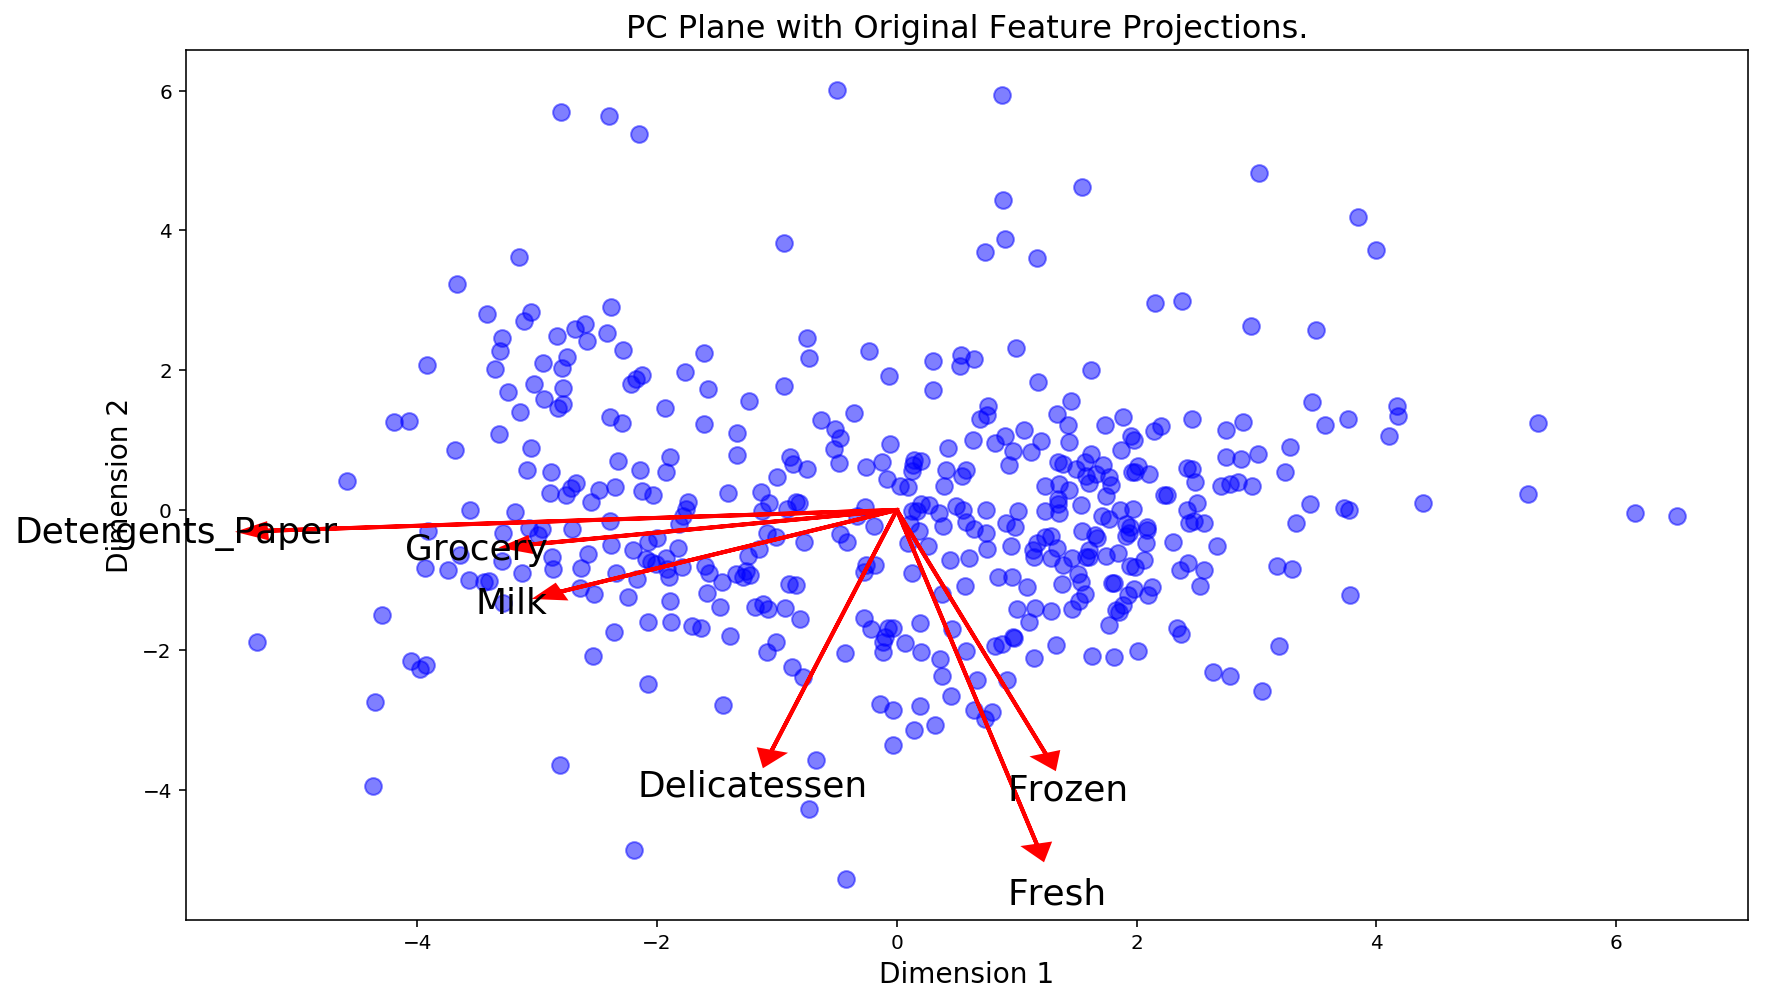

In [16]:
# Create a biplot
vs.biplot(good_data, reduced_data, pca);

### Observation

Once we have the original feature projections (in red), it is easier to interpret the relative position of each data point in the scatterplot. For instance, a point the lower right corner of the figure will likely correspond to a customer that spends a lot on `'Milk'`, `'Grocery'` and `'Detergents_Paper'`, but not so much on the other product categories.

From the biplot, we can say that annual spending on detergents and paper products is the most strongly correlated with the first component (negatively correlated), whereas annual spending on fresh products appears to be the most strongly correlated with the second component (negatively correlated).

These observations agree with the PCA results plot we obtained earlier.

---

## Clustering

In this section, we will choose to use either a K-Means clustering algorithm or a Gaussian Mixture Model clustering algorithm to identify the various customer segments hidden in the data.

We will then recover specific data points from the clusters to understand their significance by transforming them back into their original dimension and scale.

Before performing this, we can discuss advantages of both algorithms:
- K-Means clustering algorithm: It can take in charge large datasets (time complexity linearity), is adapted to circular clusters and is easy to interpret.
- Gaussian Mixture Model clustering algorithm: It doesn't impose circular clusters, neither a known precise number of clusters, it obtains good results even with non-linear geometric distributions and it offers opened interpretation options, associating for each point a given probability to belonging to each cluster.

For the previous visualization graphs, a clear number of clusters doesn't appear, neither precise shapes: Gaussian Mixture Model clustering algorithm is probably the best choice to make.

### Creating Clusters

Depending on the problem, the number of clusters that we expect to be in the data may already be known. When the number of clusters is not known *a priori*, there is no guarantee that a given number of clusters best segments the data, since it is unclear what structure exists in the data — if any. However, we can quantify the "goodness" of a clustering by calculating each data point's *silhouette coefficient*. The [silhouette coefficient](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.silhouette_score.html) for a data point measures how similar it is to its assigned cluster from -1 (dissimilar) to 1 (similar). Calculating the *mean* silhouette coefficient provides for a simple scoring method of a given clustering.

In the code block below, we are going to implement the following:
- Fit a clustering algorithm to the `reduced_data` and assign it to `clusterer`.
- Predict the cluster for each data point in `reduced_data` using `clusterer.predict` and assign them to `preds`.
- Find the cluster centers using the algorithm's respective attribute and assign them to `centers`.
- Predict the cluster for each sample data point in `pca_samples` and assign them `sample_preds`.
- Import `sklearn.metrics.silhouette_score` and calculate the silhouette score of `reduced_data` against `preds`.
- Assign the silhouette score to `score` and print the result.

In [17]:
# Determine the best number of clusters:
print("*** Mean silhouette coefficient for different numbers of clusters:")
score_max = -1.
best_n_clusters = 0

# Check results for several clusters number:
for n_clusters in range(2, 10):
    # Apply our clustering algorithm of choice to the reduced data: 
    clusterer = GaussianMixture(n_components=n_clusters,
                                covariance_type="full",
                                random_state=42).fit(reduced_data)
    # Predict the cluster for each data point:
    preds = clusterer.predict(reduced_data)
    # Find the cluster centers:
    centers = clusterer.means_
    # Predict the cluster for each transformed sample data point:
    sample_preds = clusterer.predict(pca_samples)
    # Calculate the mean silhouette coefficient for the number of clusters chosen:
    score = silhouette_score(reduced_data, preds)
    # Print and check results:
    print("Number of clusters... {}, Mean silhouette score... {:.4f}".format(n_clusters, score))
    if score > score_max:
        score_max = score
        best_n_clusters = n_clusters
    
# Results summary:
print("\n*** Summary: Best number of clusters... {},".format(best_n_clusters),
      "Mean silhouette score... {:.4f}".format(score_max))

*** Mean silhouette coefficient for different numbers of clusters:
Number of clusters... 2, Mean silhouette score... 0.4219
Number of clusters... 3, Mean silhouette score... 0.4042
Number of clusters... 4, Mean silhouette score... 0.2933
Number of clusters... 5, Mean silhouette score... 0.3005
Number of clusters... 6, Mean silhouette score... 0.3261
Number of clusters... 7, Mean silhouette score... 0.3242
Number of clusters... 8, Mean silhouette score... 0.2965
Number of clusters... 9, Mean silhouette score... 0.3072

*** Summary: Best number of clusters... 2, Mean silhouette score... 0.4219


As it can be observed, the best number of clusters is 2 (with a mean silhouette score of 0.4219).

In [18]:
# Apply our clustering algorithm of choice to the reduced data: 
clusterer = GaussianMixture(n_components=best_n_clusters,
                            covariance_type="full",
                            random_state=42).fit(reduced_data)

# Predict the cluster for each data point:
preds = clusterer.predict(reduced_data)

# Find the cluster centers:
centers = clusterer.means_

# Predict the cluster for each transformed sample data point:
sample_preds = clusterer.predict(pca_samples)

# Calculate the mean silhouette coefficient for the number of clusters chosen:
score = silhouette_score(reduced_data, preds)

### Cluster Visualization

Once we have chosen the optimal number of clusters for our clustering algorithm using the scoring metric above, we can visualize the results by executing the code block below.

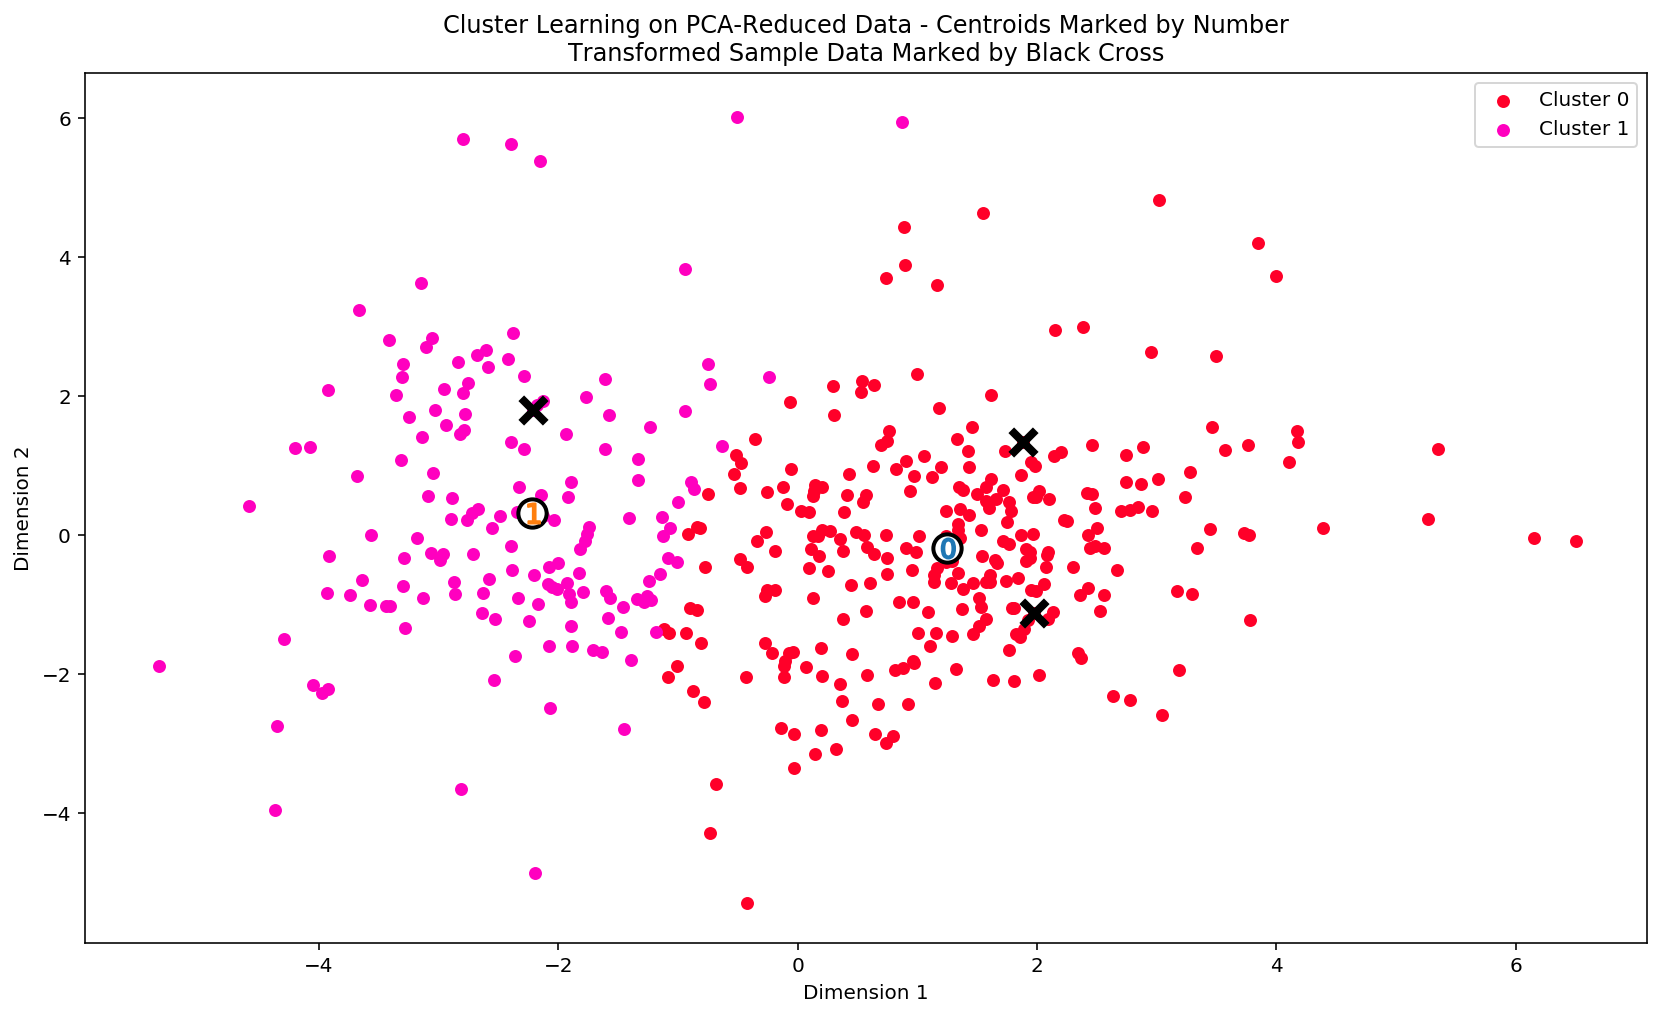

In [19]:
# Display the results of the clustering from implementation:
vs.cluster_results(reduced_data, preds, centers, pca_samples)

### Data Recovery

Each cluster present in the visualization above has a central point. These centers (or means) are not specifically data points from the data, but rather the *averages* of all the data points predicted in the respective clusters. For the problem of creating customer segments, a cluster's center point corresponds to *the average customer of that segment*. Since the data is currently reduced in dimension and scaled by a logarithm, we can recover the representative customer spending from these data points by applying the inverse transformations.

In the code block below, we are going to implement the following:
- Apply the inverse transform to `centers` using `pca.inverse_transform` and assign the new centers to `log_centers`.
- Apply the inverse function of `np.log` to `log_centers` using `np.exp` and assign the true centers to `true_centers`.

In [20]:
# Inverse transform the centers:
log_centers = pca.inverse_transform(centers)

# Exponentiate the centers:
true_centers = np.exp(log_centers)

# Display the true centers:
segments = ["Segment {}".format(i) for i in range(0, len(centers))]
true_centers = pd.DataFrame(np.round(true_centers), columns=data.keys())
true_centers.index = segments
display(true_centers)

,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicatessen
Segment 0,8953.0,2114.0,2765.0,2075.0,353.0,732.0
Segment 1,3552.0,7837.0,12219.0,870.0,4696.0,962.0


In [21]:
# Display a description of the dataset:
display(data.describe())

,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicatessen
count,440.000000,440.000000,440.000000,440.000000,440.000000,440.000000
mean,12000.297727,5796.265909,7951.277273,3071.931818,2881.493182,1524.870455
std,12647.328865,7380.377175,9503.162829,4854.673333,4767.854448,2820.105937
min,3.000000,55.000000,3.000000,25.000000,3.000000,3.000000
25%,3127.750000,1533.000000,2153.000000,742.250000,256.750000,408.250000
50%,8504.000000,3627.000000,4755.500000,1526.000000,816.500000,965.500000
75%,16933.750000,7190.250000,10655.750000,3554.250000,3922.000000,1820.250000
max,112151.000000,73498.000000,92780.000000,60869.000000,40827.000000,47943.000000


If we analyze the obtained results with the help of the statistical description of the dataset at the beginning of the project (and reproduced above), we can say that:
- Segment 0: The annual spendings on fresh and delicatessen products appear to be very close to the median value, whereas the other annual spendings on other products are more far away, we can interpret them as establishments which mainly sell direct and quick consumption products (fast foods, restaurants, cafeterias, cafes...).
- Segment 1: The annual spendings on milk, grocery, and detergents and paper products are above the third quantile, we can interpret them as important market places (retailers, supermarkets...).

In [22]:
# Display the predictions:
print("*** Sample points classification:")
for i, pred in enumerate(sample_preds):
    print("Sample point...", i, "predicted to be in cluster...", pred)

*** Sample points classification:
Sample point... 0 predicted to be in cluster... 1
Sample point... 1 predicted to be in cluster... 0
Sample point... 2 predicted to be in cluster... 0


Previously, we predicted the first establishment (sample point 0) to be an important market, prediction consistent with the classification inside cluster 1.

Considering the second establishment (sample point 1), we predicted it to be a wholesaler and food distributor specialized on fresh and frozen products (for restaurants and fast foods for example), prediction consistent with classification inside cluster 0.

Finally, considering the third establishment (sample point 2), we predicted it to be a little neighborhood market local place, prediction consistent with classification inside cluster 0, too.

---

## Conclusion

### Small Briefing

In this final section, we will investigate ways that we can make use of the clustered data.

First, we will consider how the different groups of customers, the ***customer segments***, may be affected differently by a specific delivery scheme.

Next, we will consider how giving a label to each customer (which *segment* that customer belongs to) can provide for additional features about the customer data.

Finally, we will compare the ***customer segments*** to a hidden variable present in the data, to see whether the clustering identified certain relationships.

### Specific Delivery Schemes

Companies will often run [A/B tests](https://en.wikipedia.org/wiki/A/B_testing) when making small changes to their products or services to determine whether making that change will affect its customers positively or negatively.

The wholesale distributor is considering changing its delivery service from currently 5 days a week to 3 days a week, however, the distributor will only make this change in delivery service for customers that react positively. 

How can the wholesale distributor use the customer segments to determine which customers, if any, would react positively to the change in delivery service?

From what it has been noticed above, the main differences between segment 0 and segment 1 correspond to stock size (more important for segment 1) and the nature of products (more perishable and directly consumming for segment 0). Establishments which mainly sell direct and quick consumption products (fast foods, restaurants, cafeterias, cafes...) don't conserve large stocks of products, thus, they should be affected if the delevery service changes from 5 days a week to 3 days a week. So, here, to perform A/B test for this change, it would be better to target customers from segment 1 (important market places like retailers or supermarkets).

### Engineered Feature

Additional structure is derived from originally unlabeled data when using clustering techniques. Since each customer has a ***customer segment*** it best identifies with (depending on the clustering algorithm applied), we can consider *'customer segment'* as an **engineered feature** for the data. Assume the wholesale distributor recently acquired ten new customers and each provided estimates for anticipated annual spending of each product category. Knowing these estimates, the wholesale distributor wants to classify each new customer to a ***customer segment*** to determine the most appropriate delivery service.

How can the wholesale distributor label the new customers using only their estimated product spending and the **customer segment** data?

Here, for example, the wholesale distributor can use the new engineered feature as a label for each customer in the former dataset, and, then, build, train and test a supervised learning model on the modified dataset. Thus, if a consistent model with good quality metrics is obtained, the wholesale distributor can perfectly imagine predict the label (so, the new engineered feature) of each new customer thanks to the new supervised learning built model.

### Visualizing Underlying Distributions

At the beginning of this project, it was discussed that the `'Channel'` and `'Region'` features would be excluded from the dataset so that the customer product categories were emphasized in the analysis.

By reintroducing the `'Channel'` feature to the dataset, an interesting structure emerges when considering the same PCA dimensionality reduction applied earlier to the original dataset.

Below, running the code block, it can be seen how each data point is labeled either `'HoReCa'` (Hotel/Restaurant/Cafe) or `'Retail'` in the reduced space.

*Nota Bene:* In addition, we will find the sample points are circled in the plot, which will identify their labeling.

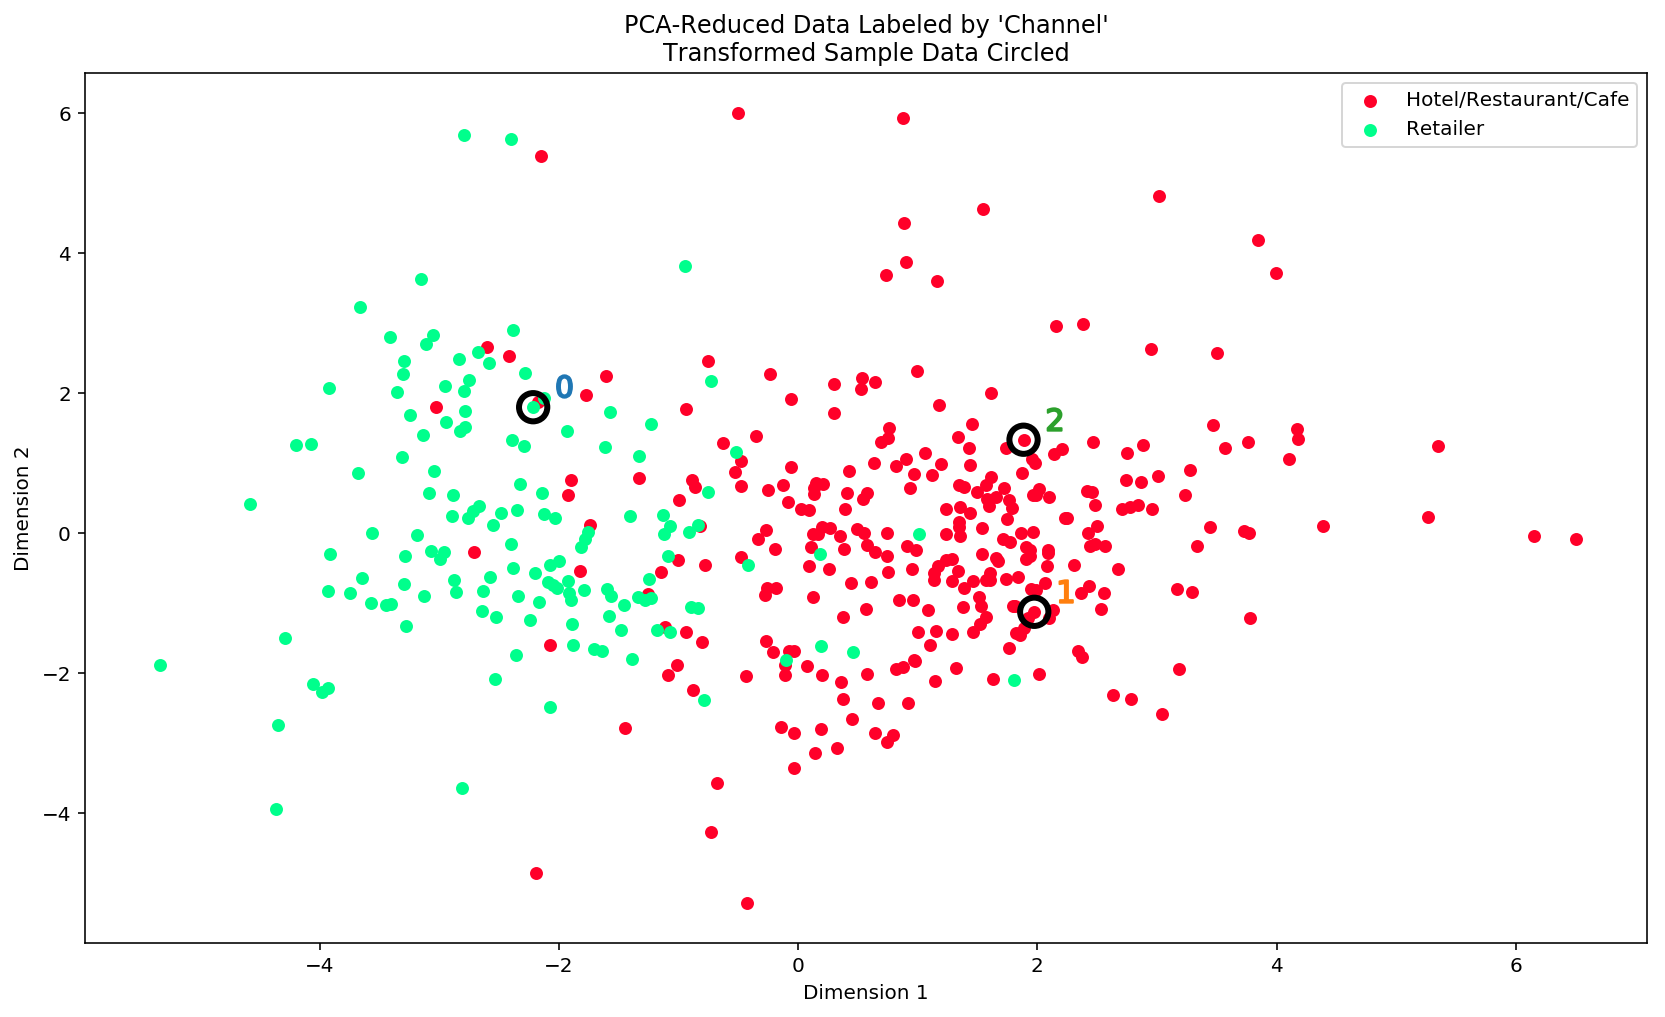

In [23]:
# Display the clustering results based on 'Channel' data:
vs.channel_results(reduced_data, remove_outliers_list, pca_samples)

Here, compared to the previous one, we can observe that the new clustering algorithm exposes a close split separation of the data points, it's all very similar, and it appears that it could be possible to define customer segments that would be classified as purely 'Retailers' (the ones whose value respectively to dimension 1 is below to -3) or as purely 'Hotels/Restaurants/Cafes' (the ones whose value respectively to dimension 1 is above to 2).

Theses classifications are very consistent with our previous definition of the customer segments, clearly.